# Model training

In [ ]:
print('Importing all libraries')
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

import cv2, IPython, PIL, time
from io import BytesIO

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
datagen = ImageDataGenerator (
            rescale = 1./255, 
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            )
images_dir = './New Masks Dataset/'
print('Files found')

Files found


In [4]:
# load the data using data generators
print('Training set: ' + images_dir + 'Train')
train_generator  =    datagen.flow_from_directory(
                             images_dir + 'Train',
                             seed=42,
                             target_size = (200,200),
                             batch_size = 64 ,               
                             class_mode = 'binary',
                            )

print('Test set: ' + images_dir + 'Test')
test_generator = datagen.flow_from_directory(
                             images_dir + 'Test' ,
                             seed=42, 
                             target_size = (200,200),
                             batch_size = 64 ,               
                             class_mode = 'binary',
                            )

print('Validation set :' + images_dir + 'Validation')
validation_generator = datagen.flow_from_directory(
                             images_dir + 'Validation' ,
                             seed=42, 
                             target_size = (200,200),
                             batch_size = 64 ,               
                             class_mode = 'binary',
                            )

Training set: ./New Masks Dataset/Train
Found 600 images belonging to 2 classes.
Test set: ./New Masks Dataset/Test
Found 111 images belonging to 2 classes.
Validation set :./New Masks Dataset/Validation
Found 306 images belonging to 2 classes.


In [5]:
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(32,(3,3),input_shape=(200,200,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(128,activation='relu'))
#Dense layer of 128 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

# model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
print('Model defnined')

Model defnined


In [7]:
model.load_weights('Test')


H = model.fit(
        train_generator,
        epochs = 2,
        validation_data = validation_generator,
        callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='Test',
                                                 save_weights_only=True,
                                                 verbose=1))
# model.save('Model/assets')
# https://www.tensorflow.org/tutorials/keras/save_and_load

Epoch 1/2
10/10 [==============================] - 26s 3s/step - loss: 0.3786 - accuracy: 0.8265 - val_loss: 0.2959 - val_accuracy: 0.8889

Epoch 00001: saving model to Test
Epoch 2/2
10/10 [==============================] - 25s 3s/step - loss: 0.2229 - accuracy: 0.9119 - val_loss: 0.3455 - val_accuracy: 0.8660

Epoch 00002: saving model to Test


In [2]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plots = ['val_accuracy','val_loss', 'accuracy', 'loss']
co = ['red','green','blue', 'orange']
cu = 0
for what in plots:
    y1 = []
    for x in H.history[what]:
        y1.append(x)
    plt.plot(H.epoch, y1, color=co[cu],linewidth = 1, label = what)
    cu +=1
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.show() 


NameError: name 'H' is not defined

In [10]:
def image_resize(image, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    r = height / float(h)
    dim = (int(w * r), height)
    return cv2.resize(image, dim, interpolation = inter)

def image_reshape(image, dimension=200): 
    image = image_resize(image, height=dimension)
    (h, w, c) = image.shape
    offset = int((w-dimension)/2)
    image = image[0:dimension, offset:dimension+offset, 0:c]
    return image
def get_frame(cam):
    ret, frame = cam.read()
    frame = cv2.flip(frame, 1)

    return frame
def array_to_image(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    return IPython.display.Image(data=f.getvalue())

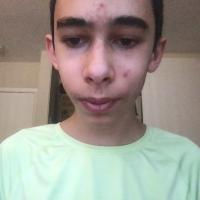

In [ ]:
from tensorflow.keras.preprocessing import image
cam = cv2.VideoCapture(1)

d = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)
d3 = IPython.display.display("", display_id=3)

while True:
    try:
        t1 = time.time()
        frame = get_frame(cam)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = image_reshape(frame, dimension=200)
        
        result = model.predict(frame.reshape(1,200,200,3))
        if result[0][0] > .5:
            prediction = 'mask'
        else :
            prediction = 'unmask'

        im = array_to_image(frame)
        d.update(im)

        t2 = time.time()

        s = f"""{int(1/(t2-t1))} FPS"""
        d2.update( IPython.display.HTML(prediction))
        d3.update( IPython.display.HTML(s))
    except KeyboardInterrupt:
        cam.release()
        IPython.display.clear_output()
        print ("Stream stopped")
        break

In [ ]:
# EXAMPLE

#For Predicting on single Image
from tensorflow.keras.preprocessing import image
# test_image = image.load_img('New Masks Dataset/Test/Mask/2300.png', target_size = (200,200,3))
test_image = image.load_img('New Masks Dataset/Test/Non Mask/real_01081.jpg', target_size = (200,200,3))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result[0])
if result[0][0] > .5:
    prediction = 'mask'
else :
    prediction = 'unmask'
print(prediction)